In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import UnivariateSpline
import sys

sys.path.append("../lib/")

from lib import master_calendar


In [2]:
df_raw = pd.read_csv("Data/concept2-season-2020.csv")


In [3]:
# columns to drop (empty, duplicated values or constant)
col_to_drop = [
    "Stroke Count",  # empty
    "Avg Heart Rate",  # empty
    "Comments",  # empty
    "Weight",  # constant
    "Type",  # constant
    "Ranked",  # constant
    "Work Time (Formatted)",  # duplicate
    "Rest Time (Formatted)",  # duplicate
    "Age",  # constant
    "Cal/Hour",  # duplicate
]
df = df_raw.drop(col_to_drop, axis="columns")

# renaming based on preferences
dict_naming = {
    "ID": "session_id",
    "Description": "session_type",
    "Date": "session_timestamp",
    "Work Time (Seconds)": "length_work_in_s",
    "Rest Time (Seconds)": "length_rest_in_s",
    "Work Distance": "length_work_in_m",
    "Rest Distance": "length_rest_in_m",
    "Stroke Rate/Cadence": "spm",
    "Pace": "time_split",
    "Total Cal": "cal_burned",
    "Drag Factor": "drag_factor",
    "Avg Watts": "power_in_avg_w",
}
df.rename(columns=dict_naming, inplace=True)

df["session_date"] = pd.to_datetime(df["session_timestamp"]).dt.date
df["session_date"] = pd.to_datetime(df["session_date"])
df["time_split"] = pd.to_datetime(df["time_split"]).dt.time


In [4]:
# get earliest and latest rowing date and generate a master calendar for the intervals
d_M = np.max(df["session_timestamp"])
d_m = np.min(df["session_timestamp"])

print(f"beginning: {d_m}\nend: {d_M}")

df_calendar = master_calendar.create_calendar(d_m, d_M)


beginning: 2019-05-04 20:29:00
end: 2019-12-10 18:37:00


In [5]:
# merge master calendar with training sessions information for temporal aggregation alter
df_cal = pd.merge(
    df,
    df_calendar,
    how="right",
    left_on=df["session_date"],
    right_on=df_calendar["MC_Date"],
)
# fill NaN values from sessions without rest with 0 (rest but equal to 0)
dict_nan = {
    "length_rest_in_s": 0,
    "length_rest_in_m": 0,
    "cal_burned": 0,
    "session_type": "None",
    "session_id": "None",
    "session_timestamp": "None",
    "length_work_in_m": 0,
    "length_work_in_s": 0,
    "spm": 0,
    "power_in_avg_w": 0,
    "drag_factor": 0,
    "time_split": 0,
}

df_cal.fillna(value=dict_nan, inplace=True)
df_cal.drop(
    ["calendar", "session_date", "key_0"], axis="columns", inplace=True
)  # duplicated information


In [6]:
df_cal["training_day"] = (df_cal["session_type"] != "None").astype(
    bool
)  # simple filter for training days
df_cal["multi_training"] = df_cal.duplicated(
    subset="MC_Date", keep=False
)  # tag for multiple sessions the same day


In [7]:
session_grouping = {
    "2000m row": "2km Row",
    "5000m row": "5km Row",
    "10000m row": "10km Row",
    "None": "None",
}

df_cal["session_type_group"] = (
    df_cal["session_type"].map(session_grouping).fillna("Other")
)

print(df_cal["session_type"].unique().tolist())
print(df_cal["session_type_group"].unique().tolist())

['1x500m/1:00r row', '5:05 row', 'None', '3x4:00/1:00r row', '10:02 row', '3x500m/1:00r row', '10:04 row', '2000m row', '2x500m/1:00r row', '30:00 row', '5000m row', '8:42 row', '2x1000m/0:30r row', '10000m row', '8:25 row', '8:24 row', '23:56 row', '24:10 row', '5:00 row', 'v2:00/r...15 row', '2x500m/2:00r row', '9:19 row', 'v2:00/r...11 row', 'v2000m/r...12 row', 'v1000m/1:00r...9 row', 'v1000m/1:00r...11 row', 'v1000m/1:00r...10 row', '18:56 row', '22:45 row']
['Other', 'None', '2km Row', '5km Row', '10km Row']


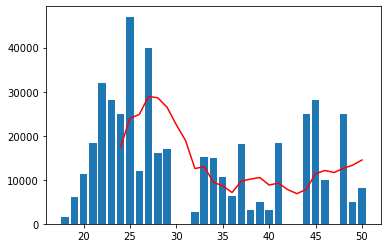

In [38]:
df_work_by_Week = df_cal.groupby(["MC_Week"])["length_work_in_m"].sum()
df_work_sma = df_work_by_Week.rolling(window=7).mean()
plt.bar(df_work_by_Week.index,df_work_by_Week)
plt.plot(df_work_sma.index,df_work_sma, color="r")

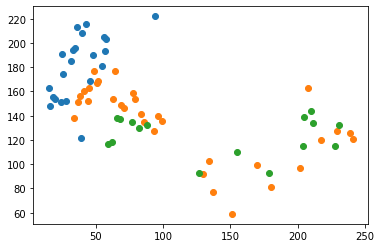

In [49]:
plt.scatter(df_cal.index[df_cal["session_type_group"]=="2km Row"],df_cal["power_in_avg_w"][df_cal["session_type_group"]=="2km Row"])
plt.scatter(df_cal.index[df_cal["session_type_group"]=="5km Row"],df_cal["power_in_avg_w"][df_cal["session_type_group"]=="5km Row"])
plt.scatter(df_cal.index[df_cal["session_type_group"]=="10km Row"],df_cal["power_in_avg_w"][df_cal["session_type_group"]=="10km Row"])
plt.show()